In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation

from sklearn.metrics import confusion_matrix, roc_curve, auc


# Initialize SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("UNSW_NB15_Analysis") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

# Creating the Schema based on the given csv file
schema = StructType([
      StructField("srcip",StringType(),True),
      StructField("sport",IntegerType(),True),
      StructField("dstip",StringType(),True),
      StructField("dsport",IntegerType(),True),
      StructField("proto",StringType(),True),
      StructField("State",StringType(),True),
      StructField("dur",FloatType(),True),
      StructField("sbytes",IntegerType(),True),
      StructField("dbytes",IntegerType(),True),
      StructField("sttl",IntegerType(),True),
      StructField("dttl",IntegerType(),True),
      StructField("sloss",FloatType(),True),
      StructField("dloss",FloatType(),True),
      StructField("service",StringType(),True),
      StructField("sload",FloatType(),True),
      StructField("dload",FloatType(),True),
      StructField("spkts",IntegerType(),True),
      StructField("dpkts",IntegerType(),True),
      StructField("swin",IntegerType(),True),
      StructField("dwin",IntegerType(),True),
      StructField("stcpb",IntegerType(),True),
      StructField("dtcpb",IntegerType(),True),
      StructField("smeansz",IntegerType(),True),
      StructField("dmeansz",IntegerType(),True),
      StructField("trans_depth",IntegerType(),True),
      StructField("res_bdy_len",IntegerType(),True),
      StructField("sjit",FloatType(),True),
      StructField("djit",FloatType(),True),
      StructField("stime",StringType(),True),
      StructField("ltime",StringType(),True),
      StructField("sintpkt",FloatType(),True),
      StructField("dintpkt",FloatType(),True),
      StructField("tcprtt",FloatType(),True),
      StructField("synack",FloatType(),True),
      StructField("ackdat",FloatType(),True),
      StructField("is_sm_ips_ports",IntegerType(),True),
      StructField("ct_state_ttl",IntegerType(),True),
      StructField("ct_flw_http_mthd",IntegerType(),True),
      StructField("is_ftp_login",IntegerType(),True),
      StructField("ct_ftp_cmd",IntegerType(),True),
      StructField("ct_srv_src",IntegerType(),True),
      StructField("ct_srv_dst",IntegerType(),True),
      StructField("ct_dst_ltm",IntegerType(),True),
      StructField("ct_src_ltm",IntegerType(),True),
      StructField("ct_src_dport_ltm",IntegerType(),True),
      StructField("ct_dst_sport_ltm",IntegerType(),True),
      StructField("ct_dst_src_ltm",IntegerType(),True),
      StructField("attack_cat",StringType(),True),
      StructField("label",IntegerType(),True)])

# Load Data
df = spark.read.csv('/Users/Salma/UNSW-NB15.csv', schema=schema, header=False)

23/12/25 22:39:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Show the first few records
df.show(5)

# Summary statistics
df.describe().show()

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|State|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|spkts|dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     sjit|     djit|     stime|     ltime|  sintpkt| dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+----------+-----+-------------+------+-----+-----+---

+-------+-----------+------------------+-----------+------------------+-------+-------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-------+--------------------+------------------+----------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-----------------+-----------------+------------------+--------------------+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------+-------------------+
|summary|      srcip|             sport|      dstip|            dsport|  proto|  State|               du

In [3]:
# Count 'None', 'NULL', '-' and NaN values in each column
for value in ['None', 'NULL', '-', None]:
    counts = df.select([count(when(col(c) == value, c)).alias(c) for c in df.columns])
    counts.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|State|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|sjit|djit|stime|ltime|sintpkt|dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|State|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|sjit|djit|stime|ltime|sintpkt|dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|State|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|sjit|djit|stime|ltime|sintpkt|dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|State|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|sjit|djit|stime|ltime|sintpkt|dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----

In [4]:
# Data cleaning
df = df.na.fill(0)
df = df.na.replace(['None', 'NULL', '-'], [None, None, None])
df = df.withColumn('attack_cat', trim(col("attack_cat")))

In [5]:
# Fill missing values in 'attack_cat' with 'Normal'
df = df.fillna({'attack_cat':'Normal'})

In [6]:
# Exploratory Data Analysis
df.select("attack_cat").describe().show()

distinct_attack_categories = df.select('attack_cat').distinct().collect()
print("Distinct Attack Categories:", distinct_attack_categories)

+-------+----------+
|summary|attack_cat|
+-------+----------+
|  count|   2539739|
|   mean|      NULL|
| stddev|      NULL|
|    min|  Analysis|
|    max|     Worms|
+-------+----------+



Distinct Attack Categories: [Row(attack_cat='Worms'), Row(attack_cat='Shellcode'), Row(attack_cat='Fuzzers'), Row(attack_cat='Analysis'), Row(attack_cat='DoS'), Row(attack_cat='Reconnaissance'), Row(attack_cat='Backdoor'), Row(attack_cat='Exploits'), Row(attack_cat='Normal'), Row(attack_cat='Generic'), Row(attack_cat='Backdoors')]


In [7]:
# Fill missing values in 'attack_cat' with 'Normal'
df = df.fillna({'attack_cat':'Normal'})

In [8]:
# Count of each attack category
df.groupBy('attack_cat').count().orderBy('count', ascending=False).show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|        Normal|2218456|
|       Generic| 215481|
|      Exploits|  44525|
|       Fuzzers|  24246|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Analysis|   2677|
|      Backdoor|   1795|
|     Shellcode|   1511|
|     Backdoors|    534|
|         Worms|    174|
+--------------+-------+



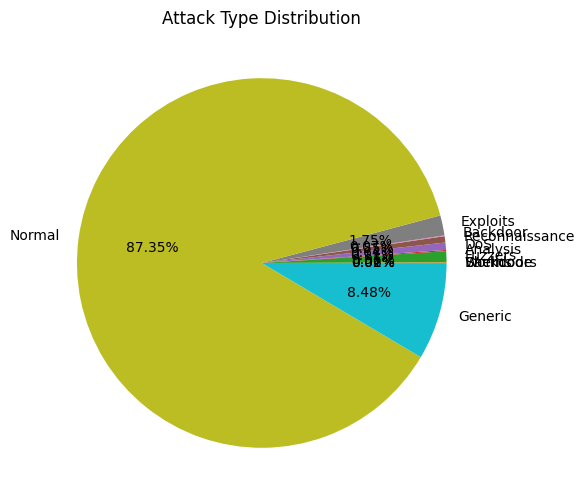

In [9]:
# Plotting function improved for reusability
def plot_pie_chart(data, title, column):
    counts = data.groupBy(column).count().collect()
    labels, values = zip(*[(row[column], row['count']) for row in counts])
    plt.figure(figsize=(10, 6))
    plt.pie(values, labels=labels, autopct='%1.2f%%')
    plt.title(title)
    plt.show()

plot_pie_chart(df, "Attack Type Distribution", "attack_cat")


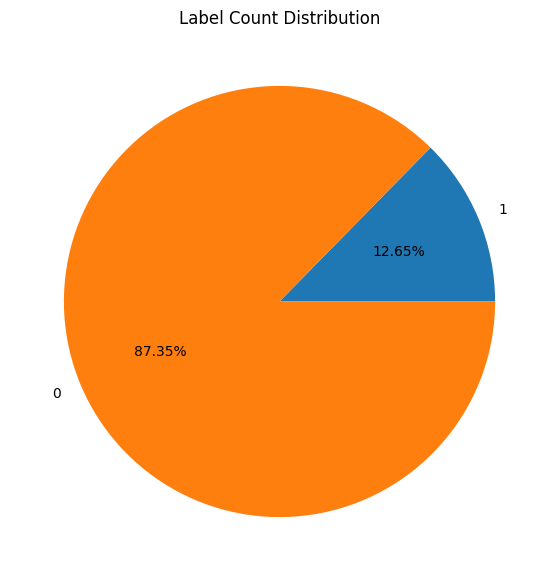

In [10]:
def plot_pie_chart(data, title):
    labels, counts = zip(*[(row['Label'], row['count']) for row in data.collect()])
    plt.figure(figsize=(7, 7))
    plt.pie(counts, labels=labels, autopct='%1.2f%%')
    plt.title(title)
    plt.show()
    
plot_pie_chart(df.groupBy("Label").count(), 'Label Count Distribution')

T-test p-value: 0.0


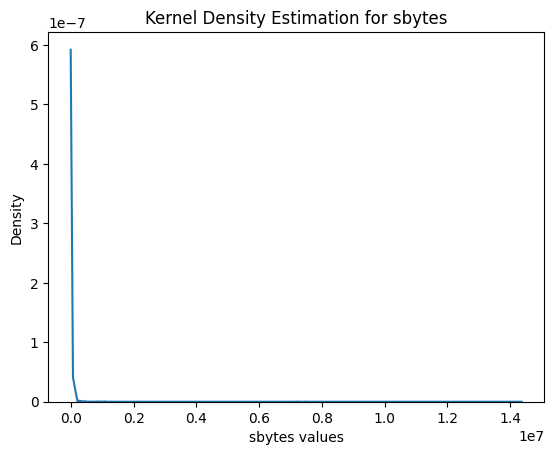

In [11]:
# Assuming df is your PySpark DataFrame
pandas_df = df.select("sbytes", "dbytes").toPandas()

# T-test
t_stat, p_value = ttest_ind(pandas_df["sbytes"], pandas_df["dbytes"])
print("T-test p-value:", p_value)

# Kernel Density Estimation
sns.kdeplot(pandas_df["sbytes"])
plt.title("Kernel Density Estimation for sbytes")
plt.xlabel("sbytes values")
plt.ylabel("Density")
plt.show()

In [12]:
# Correlation Analysis

In [13]:
# List of column names for correlation analysis
correlation_columns = ["sport", "dsport", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss",
        "sload", "dload", "spkts", "dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", 
        "dmeansz", "trans_depth", "res_bdy_len", "sjit", "djit", "sintpkt", "dintpkt",
        "tcprtt", "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd",
        "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
        "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "label"]

# Assembling features for correlation analysis
assembler = VectorAssembler(inputCols=correlation_columns, outputCol="corr_features")
df_vector = assembler.transform(df).select("corr_features")

In [14]:
# Calculating the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0].toArray()

23/12/25 22:40:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/25 22:40:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


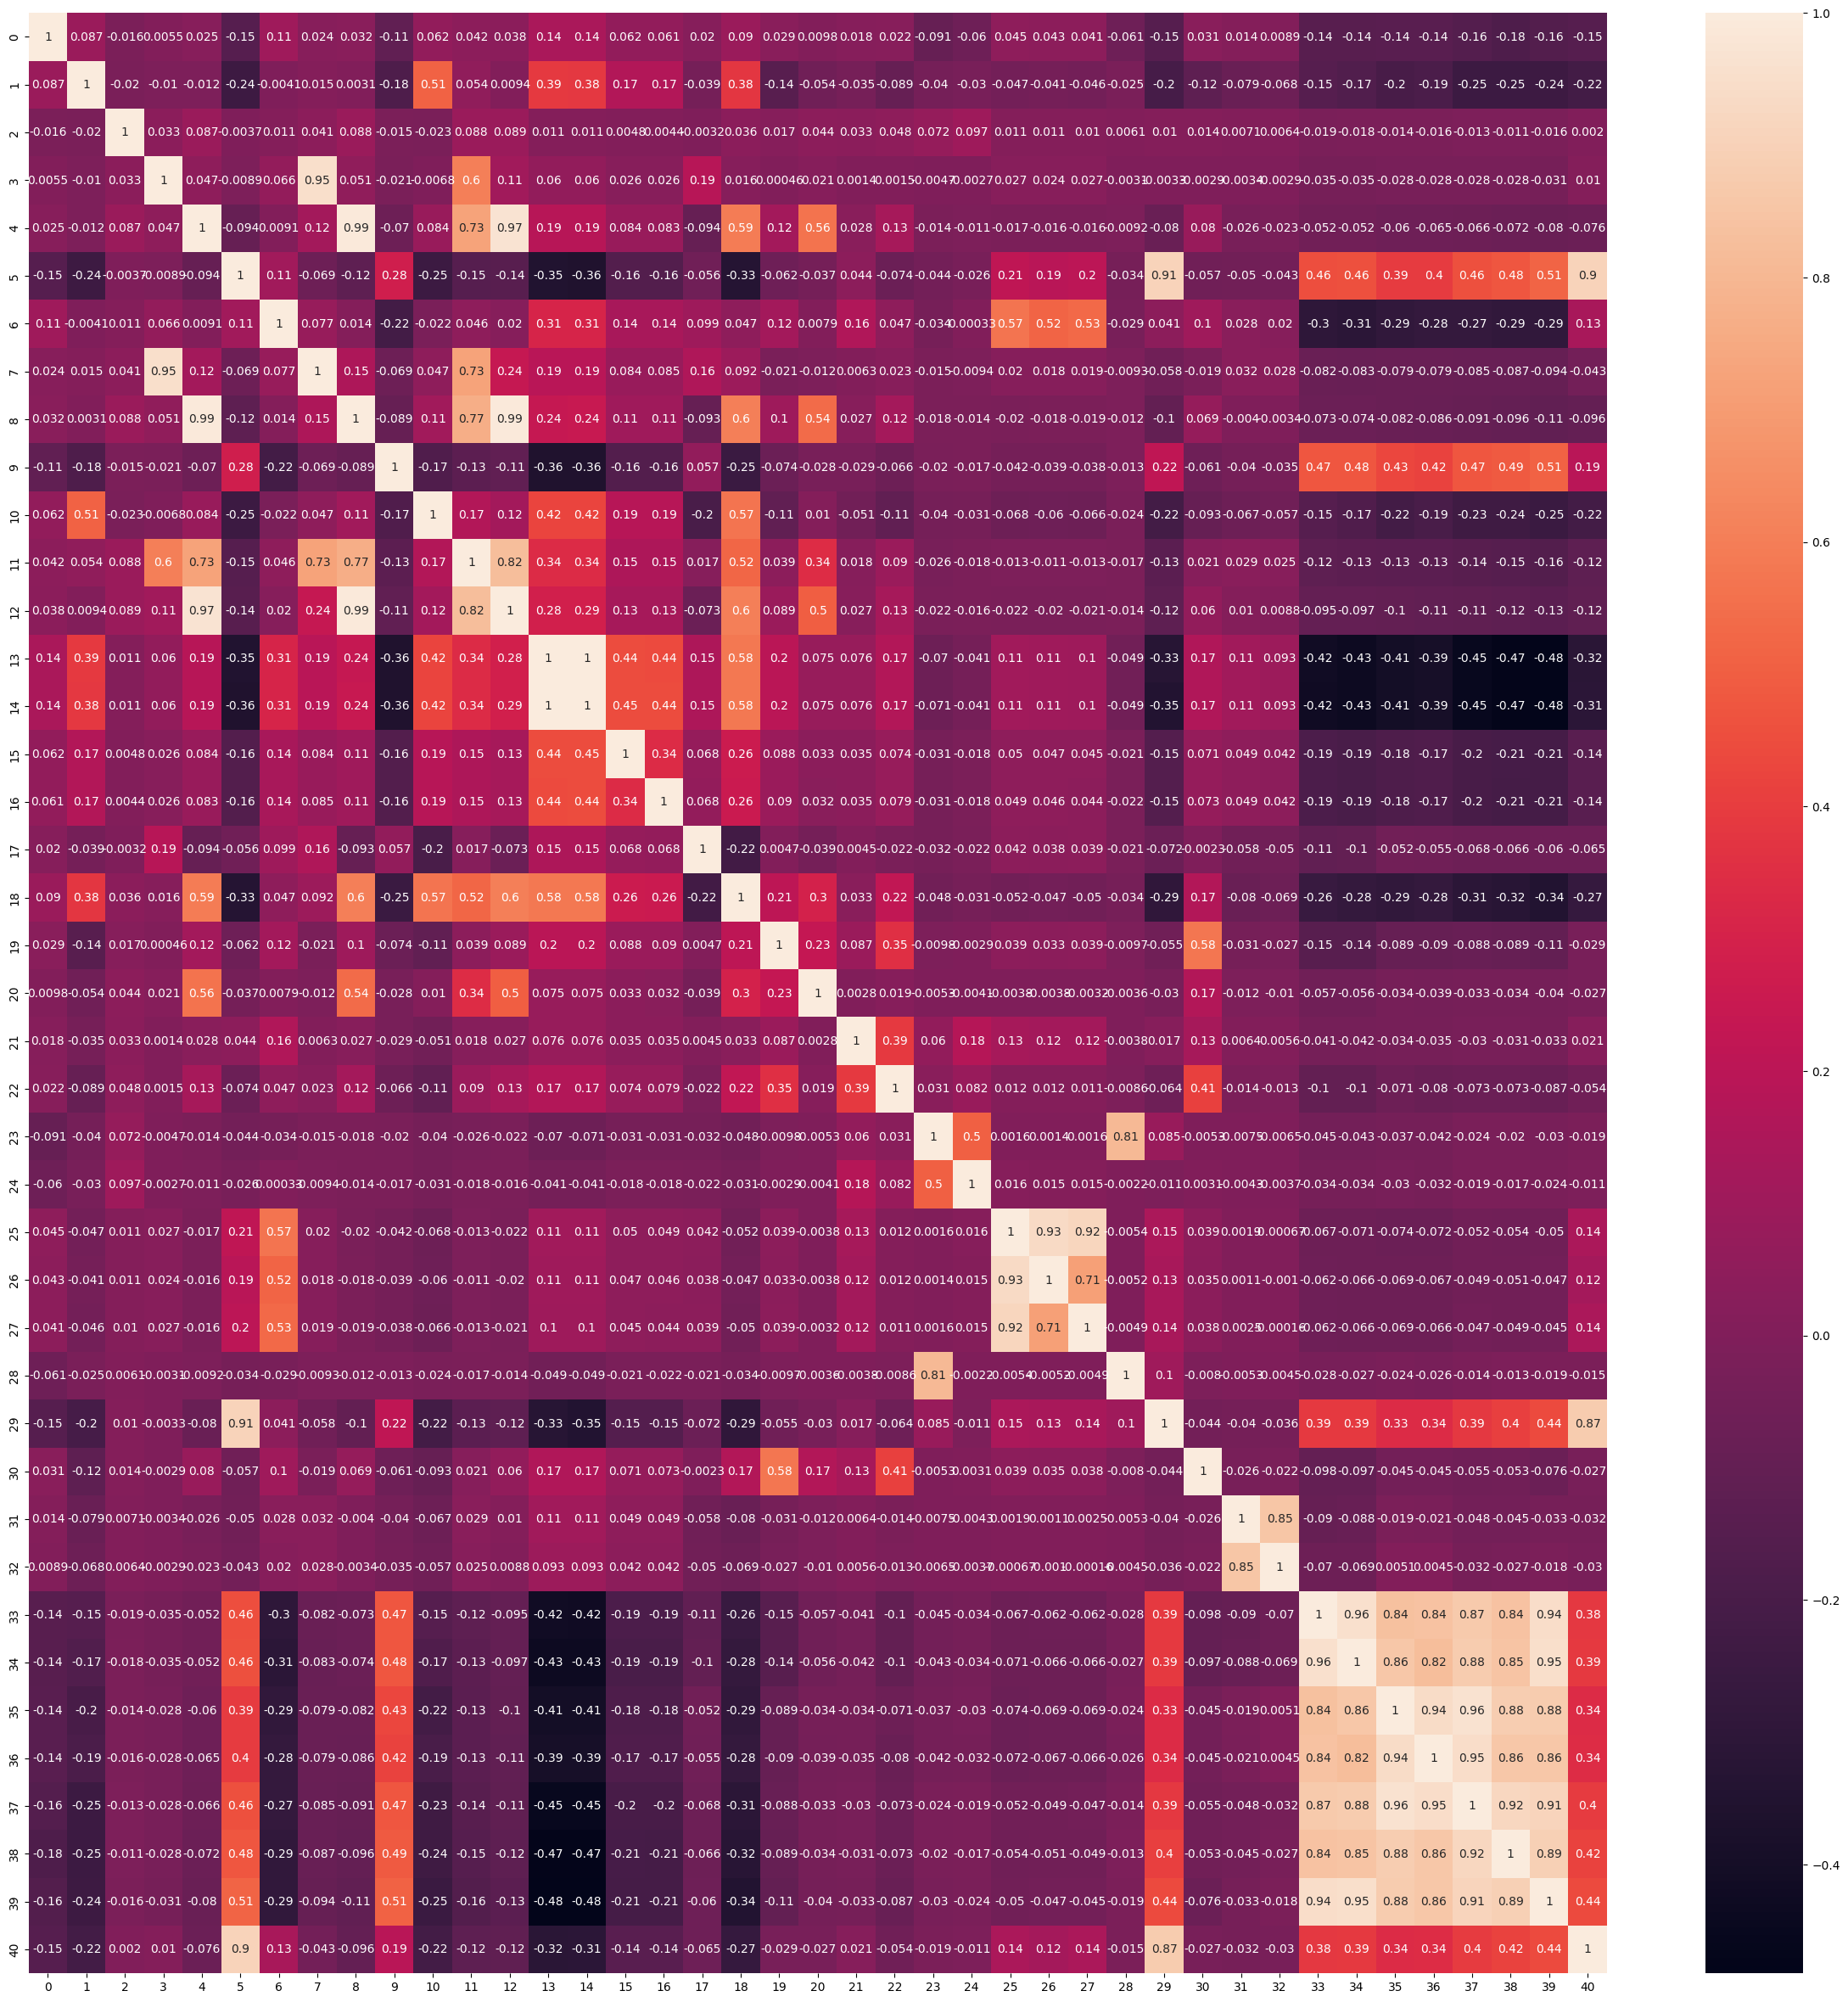

In [15]:
# Plotting heatmap of correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [16]:
df_corr_matrix = spark.createDataFrame(correlation_matrix, correlation_columns)
# Show correlation between 'sport' and 'Label'
df_corr_matrix.select('sport', 'Label').show()

+--------------------+--------------------+
|               sport|               Label|
+--------------------+--------------------+
|                 1.0|-0.14991050243790538|
| 0.08663465273462526| -0.2165437906210636|
|-0.01559980545487...|0.001957053190226714|
|0.005539006189002922|0.010177227934848416|
|0.025086590472351473|-0.07555441623027384|
|-0.14944120179161494|  0.9044106464555287|
| 0.10543046439452598| 0.13492106146685454|
|0.023603892367915512|-0.04328304858265...|
| 0.03184768265976029|-0.09586938316191847|
|-0.10969275302694864| 0.19231503846829476|
|0.061920308627760996|-0.21974337199055788|
|0.041695908271997914|-0.12090114509484741|
|0.038318384461620406|-0.11596549181350548|
| 0.13915773284089206| -0.3151937690028433|
| 0.13879034314829802|-0.31400472905624927|
|0.061643932411822776|-0.14034508135839108|
| 0.06099373625392561|-0.13980782418435403|
|0.020078079227513337|-0.06536361979939942|
| 0.08985090364755678| -0.2724486534798347|
|0.028792421896873848|-0.0290520

In [17]:
# Preparing Data for Machine Learning
input_columns = ["sport", "dsport", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss",
        "sload", "dload", "spkts", "dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", 
        "dmeansz", "trans_depth", "res_bdy_len", "sjit", "djit", "sintpkt", "dintpkt",
        "tcprtt", "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd",
        "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
        "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "label"]

assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
transformed_df = assembler.transform(df)

In [18]:
# Create a DataFrame for the model
model_data_df = transformed_df.select("features", "Label")

In [19]:
# Splitting the data into training and test sets
train_df, test_df = model_data_df.randomSplit([0.7, 0.3])

In [20]:
# Random Forest Classifier

In [21]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(labelCol="Label", numTrees=50)
rf_model = rf_classifier.fit(train_df)
rf_predictions = rf_model.transform(test_df)

23/12/25 22:42:21 WARN MemoryStore: Not enough space to cache rdd_134_3 in memory! (computed 27.3 MiB so far)
23/12/25 22:42:21 WARN MemoryStore: Not enough space to cache rdd_134_2 in memory! (computed 27.3 MiB so far)
23/12/25 22:42:21 WARN MemoryStore: Not enough space to cache rdd_134_7 in memory! (computed 27.3 MiB so far)
23/12/25 22:42:21 WARN MemoryStore: Not enough space to cache rdd_134_1 in memory! (computed 27.3 MiB so far)
23/12/25 22:42:21 WARN MemoryStore: Not enough space to cache rdd_134_4 in memory! (computed 27.3 MiB so far)
23/12/25 22:42:21 WARN BlockManager: Persisting block rdd_134_1 to disk instead.
23/12/25 22:42:21 WARN BlockManager: Persisting block rdd_134_3 to disk instead.
23/12/25 22:42:21 WARN BlockManager: Persisting block rdd_134_7 to disk instead.
23/12/25 22:42:21 WARN BlockManager: Persisting block rdd_134_4 to disk instead.
23/12/25 22:42:21 WARN BlockManager: Persisting block rdd_134_2 to disk instead.
23/12/25 22:42:21 WARN MemoryStore: Not enoug

In [22]:
# Evaluate accuracy and AUC
rf_evaluator = BinaryClassificationEvaluator(labelCol="Label")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
rf_auc = rf_evaluator.setMetricName("areaUnderROC").evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}, AUC: {rf_auc}")

Random Forest Accuracy: 0.9999999999533027, AUC: 0.9999999999221711


In [23]:
# Feature importances
print("Random Forest Feature Importances:", rf_model.featureImportances)

Random Forest Feature Importances: (41,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,21,22,23,24,25,26,27,28,29,30,33,34,35,36,37,38,39,40],[0.001391586212022867,0.0076604696155419694,0.0019012242884901337,0.07823357401151651,0.00403131279569973,0.21635937091775623,0.02452923046217637,0.0021634641882670724,0.00019534761934898127,0.014370418801284488,0.04419307068695014,0.0013396827020421636,0.015302135421471193,0.0012602528454275011,0.0004475734339781069,3.3315594339929673e-07,0.04205888061277164,0.06373073455315195,9.133271509094033e-05,0.0018269523244530718,0.00036358687361361716,0.006301625800022007,0.0075788936151885465,0.00446626216305756,0.0032583811331844646,0.004275197339029831,0.0006205585699840671,0.21459906461205458,2.5123350432258298e-05,0.0011852882184354503,0.003147684054077403,0.001015771027964088,0.00016632835147237463,0.011574320943752093,0.002441378096126223,0.0005177108542183177,0.21737587763400298])


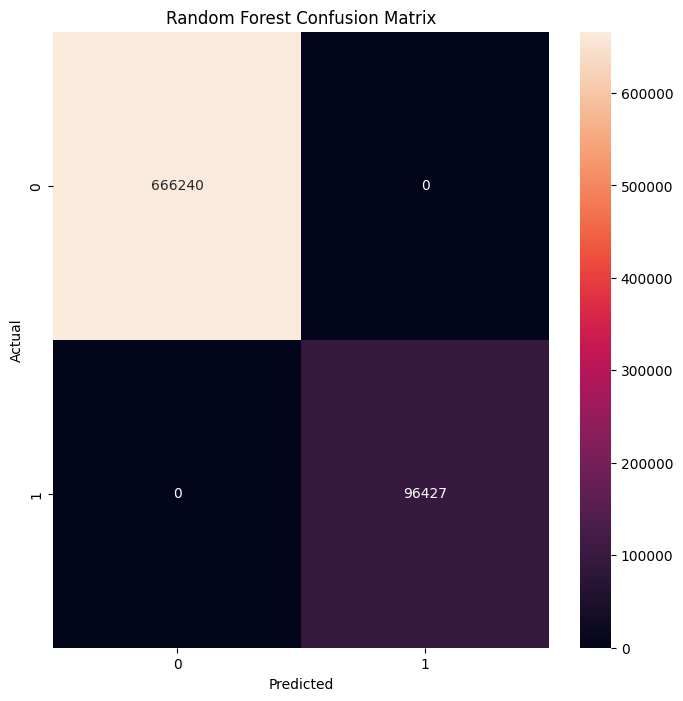

In [24]:
# Confusion Matrix for Random Forest
y_true_rf = [row['label'] for row in rf_predictions.select("label").collect()]
y_pred_rf = [row['prediction'] for row in rf_predictions.select("prediction").collect()]
conf_matrix_rf = confusion_matrix(y_true_rf, y_pred_rf)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

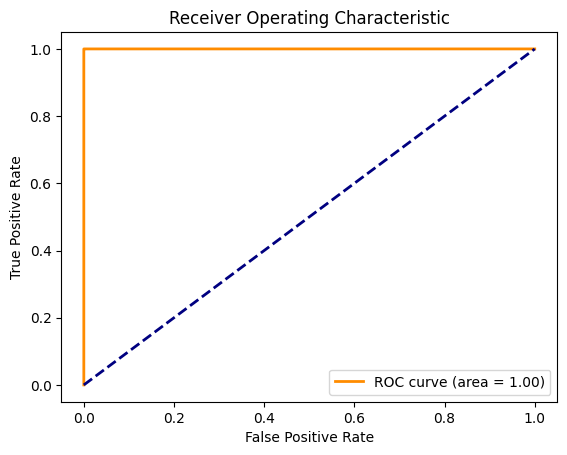

In [25]:
from pyspark.ml.linalg import DenseVector

y_true = [row['Label'] for row in rf_predictions.select("Label").collect()]
y_prob = [row['probability'] for row in rf_predictions.select("probability").collect()]
y_prob_positive = [prob[1] for prob in y_prob if isinstance(prob, DenseVector)]
fpr, tpr, thresholds = roc_curve(y_true, y_prob_positive)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Decision Tree Classifier for Multi-Class Classification
indexer = StringIndexer(inputCol="attack_cat", outputCol="attack_cat_index")
df_indexed = indexer.fit(df).transform(df)
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
multi_model_data = assembler.transform(df_indexed).select("features", "attack_cat_index")

In [27]:
# Splitting the data
train_df, test_df = multi_model_data.randomSplit([0.7, 0.3])

In [28]:
# Train multi-class Decision Tree Classifier
dt_multi_classifier = DecisionTreeClassifier(labelCol="attack_cat_index").fit(train_df)
dt_predictions = dt_multi_classifier.transform(train_df)

23/12/25 22:45:22 WARN MemoryStore: Not enough space to cache rdd_250_1 in memory! (computed 45.1 MiB so far)
23/12/25 22:45:22 WARN MemoryStore: Not enough space to cache rdd_250_7 in memory! (computed 45.1 MiB so far)
23/12/25 22:45:22 WARN MemoryStore: Not enough space to cache rdd_250_2 in memory! (computed 45.1 MiB so far)
23/12/25 22:45:22 WARN BlockManager: Persisting block rdd_250_2 to disk instead.
23/12/25 22:45:22 WARN BlockManager: Persisting block rdd_250_7 to disk instead.
23/12/25 22:45:22 WARN BlockManager: Persisting block rdd_250_1 to disk instead.
23/12/25 22:45:22 WARN MemoryStore: Not enough space to cache rdd_250_6 in memory! (computed 19.9 MiB so far)
23/12/25 22:45:22 WARN MemoryStore: Not enough space to cache rdd_250_4 in memory! (computed 19.9 MiB so far)
23/12/25 22:45:22 WARN BlockManager: Persisting block rdd_250_4 to disk instead.
23/12/25 22:45:22 WARN BlockManager: Persisting block rdd_250_6 to disk instead.
23/12/25 22:45:22 WARN MemoryStore: Not enoug

In [29]:
# Evaluate multi-class classifier
multi_evaluator = MulticlassClassificationEvaluator(labelCol="attack_cat_index")
dt_accuracy = multi_evaluator.setMetricName("accuracy").evaluate(dt_predictions)
dt_precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(dt_predictions)
dt_recall = multi_evaluator.setMetricName("weightedRecall").evaluate(dt_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy}, Precision: {dt_precision}, Recall: {dt_recall}")

Decision Tree Accuracy: 0.9835928958443176, Precision: 0.9847485783097617, Recall: 0.9835928958443176


In [31]:
# Naive Bayes Classifier
nb_classifier = NaiveBayes(labelCol="attack_cat_index", featuresCol="features")

train_data, test_data = df.randomSplit([0.7, 0.3])

nb_classifier = NaiveBayes(labelCol="attack_cat_index", featuresCol="features")
nb_pipeline = Pipeline(stages=[indexer, assembler, nb_classifier])
nb_model = nb_pipeline.fit(train_data)
nb_predictions = nb_model.transform(test_data)

In [32]:
# Evaluate Naive Bayes Model
nb_evaluator = MulticlassClassificationEvaluator(labelCol="attack_cat_index", predictionCol="prediction")
nb_accuracy = nb_evaluator.setMetricName("accuracy").evaluate(nb_predictions)
nb_precision = nb_evaluator.setMetricName("weightedPrecision").evaluate(nb_predictions)
nb_recall = nb_evaluator.setMetricName("weightedRecall").evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}, Precision: {nb_precision}, Recall: {nb_recall}")

Naive Bayes Accuracy: 0.643985197642432, Precision: 0.8833735140510732, Recall: 0.6439851976424319


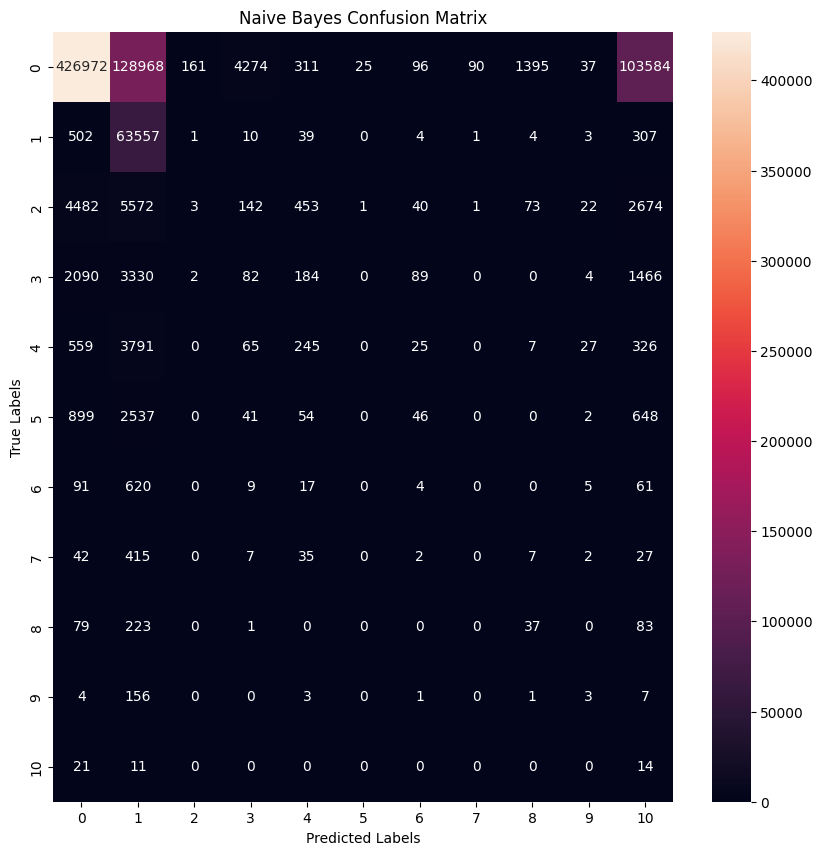

In [34]:
# Confusion Matrix for Naive Bayes
y_true_nb = [row['attack_cat_index'] for row in nb_predictions.select("attack_cat_index").collect()]
y_pred_nb = [row['prediction'] for row in nb_predictions.select("prediction").collect()]
conf_matrix_nb = confusion_matrix(y_true_nb, y_pred_nb)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_nb, annot=True, fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Clean up
spark.stop()